# Producing the Julia Microbenchmarks plot

In [1]:
# Load the required Julia packages
using DataFrames
using Gadfly
using CSV
using StatsBase

In [2]:
# Load benchmark data from file
benchmarks = CSV.read("benchmarks.csv"; header=["language", "benchmark", "time"])

# Capitalize and decorate language names from datafile
dict = Dict("c"=>"C", "julia"=>"Julia", "lua"=>"LuaJIT", "fortran"=>"Fortran", "java"=>"Java",
    "javascript"=>"JavaScript", "matlab"=>"Matlab", "mathematica"=>"Mathematica", 
    "python"=>"Python", "octave"=>"Octave", "r"=>"R", "rust"=>"Rust", "go"=>"Go");
benchmarks[:language] = [dict[lang] for lang in benchmarks[:language]]

# Normalize benchmark times by C times
ctime = benchmarks[benchmarks[:language].== "C", :]
benchmarks = join(benchmarks, ctime, on=:benchmark, makeunique=true)
delete!(benchmarks, :language_1)
rename!(benchmarks, :time_1 =>:ctime)
benchmarks[:normtime] = benchmarks[:time] ./ benchmarks[:ctime];

# Compute the geometric mean for each language
langs = [];
means = [];
priorities = [];
for lang in values(dict)
    data = benchmarks[benchmarks[:language].== lang, :]
    gmean = geomean(data[:normtime])
    push!(langs, lang)
    push!(means, gmean)
    if (lang == "C")
        push!(priorities, 1)
    elseif (lang == "Julia")
        push!(priorities, 2)        
    else
        push!(priorities, 3)
    end
end

# Add the geometric means back into the benchmarks dataframe
langmean = DataFrame(language=langs, geomean = means, priority = priorities)
benchmarks = join(benchmarks, langmean, on=:language)

# Put C first, Julia second, and sort the rest by geometric mean
sort!(benchmarks, [:priority, :geomean]);
sort!(langmean,   [:priority, :geomean]);

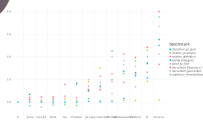

In [3]:
p = plot(benchmarks,
    x = :language,
    y = :normtime,
    color = :benchmark,
    Scale.y_log10,
    Guide.ylabel(nothing),
    Guide.xlabel(nothing),
    Coord.Cartesian(xmin=1,xmax=13.3,ymin=-0.5,ymax=4.2),
    Theme(
        guide_title_position = :left,
        colorkey_swatch_shape = :circle,
        minor_label_font = "Georgia",
        major_label_font = "Georgia"
    ),
)
draw(SVG(8inch,8inch/golden), p)

In [4]:
draw(SVG("../images/benchmarks.svg", 9inch, 9inch/golden), p)

false

In [5]:
# Show geometric means of microbenchmarks by language
langmean[:,1:2]

,language,geomean
1,C,1.0
2,Julia,1.17006
3,LuaJIT,1.09231
4,Rust,1.0999
5,Go,1.49917
6,Fortran,1.67022
7,Java,3.46773
8,JavaScript,4.79602
9,Matlab,9.57235
10,Mathematica,14.6387
